<div
    align="center"
    style="
        background-color: #082f49; 
        font-size: 30px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1.5; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h1>Data Science Salaries Analysis</h1>
</div>


<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    >
>
    <h3s1 - General Setup</h3>
</div>

<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h3>1 - General setup</h3>
</div>

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>1.1 - Import libraries</h4>
</div>

In [97]:
import os
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import plotly.io as pio
from skimpy import skim
import matplotlib as mpl
import matplotlib.pyplot as plt

import psycopg2
from psycopg2.extras import execute_batch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import statsmodels.api as sm
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import LabelEncoder

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>1.2 - Visualization setup</h4>
</div>

In [101]:
# pio.renderers.default = 'notebook'
pio.renderers.default = 'jupyterlab'

%matplotlib inline 
# Charts displayed within cells
sns.set_theme(style="dark")
plt.style.use('dark_background')

# Modify display settings
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Ignore warnings
warnings.filterwarnings("ignore")

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>1.3 - General functions</h4>
</div>

In [63]:
def styleDF(
    df,
    cmap_colors=["#e5e7eb","#172554"],
    font_size="14pt",
    header_font_size="16pt",
    padding="8px"
):
    """
    Apply custom styling to a pandas DataFrame for improved visualization in Jupyter Notebooks.

    Parameters:
        df (pd.DataFrame): The pandas DataFrame to style.
        cmap_colors (list of str, optional): A list of two hex color codes to create a custom gradient colormap 
            for background styling. Default is ["#e5e7eb", "#172554"].
        font_size (str, optional): The font size for the table cell text. Default is "14pt".
        header_font_size (str, optional): The font size for the table header text. Default is "16pt".
        padding (str, optional): The padding around table cell content. Default is "8px".

    Returns:
        pd.io.formats.style.Styler: A styled pandas DataFrame object, which can be displayed 
        in Jupyter Notebooks or converted to other formats.
    """
    # Create color map
    customCMap = mpl.colors.LinearSegmentedColormap.from_list("customCMap", cmap_colors)

    # Style the DataFrame
    return df.style\
        .set_properties(**{
            'font-size': font_size,
            'text-align': 'center',
            'padding': padding
        })\
        .set_table_styles(
            [{
                'selector': 'th', 
                'props': [
                    ('font-size', header_font_size), 
                    ('text-align', 'center'), 
                    ('padding', padding)
                ]
            }]  
        )\
        .background_gradient(cmap=customCMap)

def createTable(cursor, tableName, df):
    """
    Creates a table based on a dataframe schema and inserts its rows into the table.

    Args:
        cursor: The database cursor for executing SQL commands.
        tableName: The name of the table to create and populate.
        df: The dataframe to use for table schema and data.
    """
    # Infer column types from the dataframe
    dataType = {
        'int64': 'INTEGER',
        'float64': 'FLOAT',
        'object': 'TEXT',
        'bool': 'BOOLEAN',
        'datetime64[ns]': 'TIMESTAMP',
    }
    columnsTypes = {col: dataType[str(dtype)] for col, dtype in df.dtypes.items()}
    
    # Create column definitions for SQL
    columns = ", ".join([f"{col} {dtype}" for col, dtype in columnsTypes.items()])
    
    # Create the table
    queryCreateTable = f"""
        CREATE TABLE IF NOT EXISTS {tableName} (
            {columns}
        );
    """
    cursor.execute(queryCreateTable)
    
    # Insert rows into the table using batch insert
    values = ", ".join(["%s"] * len(df.columns))
    queryInsertRows = f"INSERT INTO {tableName} VALUES ({values});"
    
    # Convert the dataframe rows to tuples
    rows = [tuple(row) for row in df.itertuples(index=False, name=None)]
    
    # Use execute_batch for better performance with many rows
    execute_batch(cursor, queryInsertRows, rows)


<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h3>2 - Initial data visualization and inspection</h3>
</div>

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>2.1 - Load dataset</h4>
</div>

In [64]:
# Build dynamic file path
homeDirectory = os.path.expanduser("~")
filePath = os.path.join(
    homeDirectory,
    r'Desktop\Data Science Salaries\DataScience_salaries_2024.csv'
)

# Load CSV file
dfSalaries = pd.read_csv(filePath)

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>2.2 - Visualize data structure</h4>
</div>

In [65]:
skim(dfSalaries)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14838  │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 11     │ │ int32       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p50    ┃ p75    ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ work_year       │   0 │     0 │    2023 │  0.7008 │   2020 │    2023 │   2023 │   2024 │     2024 │    ▂▇▅ │  │
│ │ salary          │   0 │     0 │  165000 │  356200 │  14000 │  102100 │ 142200 │ 187500 │ 30400000 │   ▇    │  │
│ │ salary_in_usd   │   0 │     0 │  149900 │   69010 │  15000 │  102000 │ 141300 │ 185900 │   800000 │  ▇▆▁   │  │
│ │ remote_ratio    │   0 │     0 │   32.76 │   46.49 │      0 │       0 │      0 │    100 │      100 │ ▇    ▃ │  │
│ └─────────────────┴─────┴───────┴─────────┴─────────┴────────┴─────────┴────────┴────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ experience_level                   │      0 │         0 │                         1 │                14838 │  │
│ │ employment_type                    │      0 │         0 │                         1 │                14838 │  │
│ │ job_title                          │      0 │         0 │                       2.2 │                33024 │  │
│ │ salary_currency                    │      0 │         0 │                         1 │                14838 │  │
│ │ employee_residence                 │      0 │         0 │                         1 │                14838 │  │
│ │ company_location                   │      0 │         0 │                         1 │                14838 │  │
│ │ company_size                       │      0 │         0 │                         1 │                14838 │  │
│ └────────────────────────────────────┴────────┴───────────┴───────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>2.3 - Visualize general data redundancy</h4>
</div>

In [66]:
pd.DataFrame({
    'Count':dfSalaries.shape[0],
    'Null':dfSalaries.isnull().sum(),
    'Null %':dfSalaries.isnull().mean() * 100,
    'Unique':dfSalaries.nunique(),
    'Duplicated':(dfSalaries.duplicated() == True).sum()
})

,Count,Null,Null %,Unique,Duplicated
work_year,14838,0,0,5,5711
experience_level,14838,0,0,4,5711
employment_type,14838,0,0,4,5711
job_title,14838,0,0,153,5711
salary,14838,0,0,2363,5711
salary_currency,14838,0,0,23,5711
salary_in_usd,14838,0,0,2730,5711
employee_residence,14838,0,0,88,5711
remote_ratio,14838,0,0,3,5711
company_location,14838,0,0,77,5711


<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h3>3 - Data cleaning and transformation</h3>
</div>

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.1 - Detect outliers</h4>
</div>

In [67]:
# Find Q1, Q2, Q3 and calculate IQR, MIN, MAX
Q1 = dfSalaries["salary_in_usd"].quantile(0.25)
Q2 = dfSalaries["salary_in_usd"].quantile(0.50)
Q3 = dfSalaries["salary_in_usd"].quantile(0.75)
print(f"Q1={Q1}, Q2={Q2}, Q3={Q3}\n")

IQR = Q3 - Q1
print(f"IQR={IQR}\n")

lowerBound = Q1 - (1.5 * IQR)
upperBound = Q3 + (1.5 * IQR)

print(f"MIN={lowerBound}, MAX={upperBound}")

Q1=102000.0, Q2=141300.0, Q3=185900.0

IQR=83900.0

MIN=-23850.0, MAX=311750.0


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.2 - Handle outliers</h4>
</div>

In [68]:
# Detect outliers
salaryData = dfSalaries['salary_in_usd']
outliers = salaryData[(salaryData < lowerBound) | (salaryData > upperBound)]
outliersCount = len(outliers)

print(f"Quantity of outliers: {outliersCount}")

# Delete outliers
dfSalaries = dfSalaries[~dfSalaries['salary_in_usd'].isin(outliers)]

Quantity of outliers: 270


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.3 - Rename experience levels</h4>
</div>

In [69]:
def mapExpLevel(df, oldCol='experience_level', newCol='experience_level'):
    expLevel = {
        'EN': 'Junior',
        'MI': 'Mid-Level',
        'SE': 'Senior',
        'EX': 'Expert'
    }

    df[newCol] = df[oldCol].replace(expLevel)
    return df

dfSalaries = mapExpLevel(dfSalaries)

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.4 - Visualize new experience levels</h4>
</div>

In [102]:
# Count each type
empExpCounts = dfSalaries['experience_level'].value_counts()

# Create dataframe
dfEmpExpCounts = empExpCounts.reset_index()
dfEmpExpCounts.columns = ['Experience Level', 'Count']

# Create colors map
dfEmpExpCountsColors = mpl.colors.LinearSegmentedColormap.from_list("custom_blue", ["#e5e7eb", "#172554"])

# Visualize new data
styleDF(dfEmpExpCounts)

,Experience Level,Count
0,Senior,9496
1,Mid-Level,3514
2,Junior,1146
3,Expert,412


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.5 - Rename employment types</h4>
</div>

In [71]:
def mapEmploymentType(df, oldCol='employment_type', newCol='employment_type'):
    employmentType = {
        'FT': 'Full-Time',
        'PT': 'Part-Time',
        'CT': 'Contract',
        'FL': 'Freelance'
    }

    df[newCol] = df[oldCol]\
        .map(employmentType)\
        .fillna('Other')

    return df

dfSalaries = mapEmploymentType(dfSalaries)

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.6 - Visualize new employment types</h4>
</div>

In [72]:
# Count each type
empTypeCounts = dfSalaries['employment_type'].value_counts()

# Create dataframe
dfEmpTypeCounts = empTypeCounts.reset_index()
dfEmpTypeCounts.columns = ['Employment Type', 'Count']

# Create colors map
dfEmpTypeCountsColors = mpl.colors.LinearSegmentedColormap.from_list("custom_blue", ["#e5e7eb", "#172554"])

# Visualize new data
styleDF(dfEmpTypeCounts)

,Employment Type,Count
0,Full-Time,14504
1,Part-Time,27
2,Contract,24
3,Freelance,13


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.7 - Rename employment models</h4>
</div>

In [73]:
def mapEmploymentModel(df, oldCol='remote_ratio', newCol='employment_model'):

    employmentModel = {
        0: 'In-Person',
        50: 'Hybrid',
        100: 'Remote'
    }

    df[newCol] = df[oldCol].map(employmentModel).fillna('Other')

    return df

dfEmploymentModel = mapEmploymentModel(dfSalaries)

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.8 - Visualize new employment models</h4>
</div>

In [74]:
# Count each type
empModelCounts = dfSalaries['employment_model'].value_counts()

# Create dataframe
dfEmpModelCounts = empModelCounts.reset_index()
dfEmpModelCounts.columns = ['Employment Model', 'Count']

# Create colors map
dfEmpModelCountsColors = mpl.colors.LinearSegmentedColormap.from_list("custom_blue", ["#e5e7eb", "#172554"])

# Visualize new data
styleDF(dfEmpModelCounts)

,Employment Model,Count
0,In-Person,9638
1,Remote,4686
2,Hybrid,244


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.9 - Add job category column</h4>
</div>

In [75]:
def mapJobCategory(df, oldCol='job_title', newCol='job_category'):
    jobGroup = {
        'data analyst': 'Data Analyst',
        'bi analyst': 'Data Analyst',
        'analytics': 'Data Analyst',
        'data scientist': 'Data Scientist',
        'data science': 'Data Scientist',
        'decision scientist': 'Data Scientist',
        'data engineer': 'Data Engineer',
        'etl': 'Data Engineer',
        'pipeline': 'Data Engineer',
        'machine learning': 'ML Engineer',
        'ml': 'ML Engineer',
        'deep learning': 'ML Engineer',
        'ai': 'ML Engineer',
        'data architect': 'Data Engineer',
        'big data': 'Data Engineer',
        'cloud data': 'Data Engineer',
        'data manager': 'Data Engineer',
        'head of data': 'Data Engineer',
        'director': 'Data Engineer',
        'bi developer': 'Data Analyst',
        'power bi': 'Data Analyst',
        'business intelligence': 'Data Analyst',
        'research scientist': 'Data Scientist',
        'research engineer': 'Data Scientist',
        'statistician': 'Data Analyst',
        'quantitative': 'Data Analyst',
        'computational biologist': 'Data Scientist',
        'robotics': 'Data Engineer',
        'nlp': 'Data Engineer',
        'applied scientist': 'Data Scientist',
        'research analyst': 'Data Analyst',
        'data specialist ': 'Data Scientist',
        'data modeler': 'Data Engineer',
    }

    df[newCol] = df[oldCol].str.lower().apply(
        lambda title: next((v for k, v in jobGroup.items() if k in title), 'Data Scientist')
    )
    return df

dfSalaries = mapJobCategory(dfSalaries)

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.10 - Visualize new job category column</h4>
</div>

In [76]:
# Count each type
jobCategoryCounts = dfSalaries['job_category'].value_counts()

# Create dataframe
dfJobCategoryCounts = jobCategoryCounts.reset_index()
dfJobCategoryCounts.columns = ['Job Category', 'Count']

# Create colors map
dfJobCategoryCountsColors = mpl.colors.LinearSegmentedColormap.from_list("custom_blue", ["#e5e7eb", "#172554"])

# Visualize new data
styleDF(dfJobCategoryCounts)

,Job Category,Count
0,Data Scientist,5101
1,Data Engineer,3896
2,Data Analyst,3478
3,ML Engineer,2093


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>3.11 - Remove unused columns</h4>
</div>

In [77]:
dfSalaries = dfSalaries.drop(columns=[
    'remote_ratio',
    'salary_currency',
    'salary'
])

print( dfSalaries.columns )

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'company_location',
       'company_size', 'employment_model', 'job_category'],
      dtype='object')


<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h3>4 - Data modeling and structuring</h3>
</div>

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>4.1 - Create employee dataframe</h4>
</div>

In [78]:
# Create Employee dataframe
dfEmployee = dfSalaries[['work_year', 'experience_level', 'employee_residence']].drop_duplicates().reset_index(drop=True)
dfEmployee['employee_id'] = range(1, len(dfEmployee) + 1)

# Display Employee dataframe
print("Employee Table")
print(dfEmployee.head(10))

Employee Table
   work_year experience_level employee_residence  employee_id
0       2021        Mid-Level                 CL            1
1       2021        Mid-Level                 HU            2
2       2020        Mid-Level                 HU            3
3       2021        Mid-Level                 JP            4
4       2022           Senior                 IN            5
5       2021           Senior                 IN            6
6       2022           Junior                 HU            7
7       2022           Expert                 IN            8
8       2022           Junior                 JP            9
9       2023        Mid-Level                 IN           10


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>4.2 - Create job dataframe</h4>
</div>

In [79]:
# Create Job dataframe
dfJob = dfSalaries[['job_title', 'job_category', 'employment_type', 'employment_model']].drop_duplicates().reset_index(drop=True)
dfJob['job_id'] = range(1, len(dfJob) + 1)

# Display Job dataframe
print("\nJob Table")
print(dfJob.head(10))


Job Table
                        job_title    job_category employment_type  \
0                  Data Scientist  Data Scientist       Full-Time   
1                 BI Data Analyst    Data Analyst       Full-Time   
2                  Data Scientist  Data Scientist       Full-Time   
3                     ML Engineer     ML Engineer       Full-Time   
4  Lead Machine Learning Engineer     ML Engineer       Full-Time   
5            Data Science Manager  Data Scientist       Full-Time   
6        Head of Machine Learning     ML Engineer       Full-Time   
7               Research Engineer  Data Scientist       Full-Time   
8            Head of Data Science  Data Scientist       Full-Time   
9                   AI Programmer     ML Engineer       Full-Time   

  employment_model  job_id  
0           Remote       1  
1           Hybrid       2  
2           Hybrid       3  
3           Hybrid       4  
4           Hybrid       5  
5           Hybrid       6  
6           Hybrid       7

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>4.3 - Create company dataframe</h4>
</div>

In [80]:
# Create Company dataframe
dfCompany = dfSalaries[['company_location', 'company_size']].drop_duplicates().reset_index(drop=True)
dfCompany['company_id'] = range(1, len(dfCompany) + 1)

# Display Company dataframe
print("\nCompany Table")
print(dfCompany.head(10))


Company Table
  company_location company_size  company_id
0               CL            L           1
1               US            L           2
2               HU            L           3
3               JP            S           4
4               IN            L           5
5               HU            M           6
6               JP            L           7
7               IN            S           8
8               ID            L           9
9               DE            L          10


<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>4.4 - Create salary dataframe</h4>
</div>

In [81]:
# Create Salary dataframe
dfSalary = dfSalaries[['job_title', 'company_location', 'salary_in_usd']].copy()
dfSalary = dfSalary.merge(dfJob[['job_title', 'job_id']], on='job_title')
dfSalary = dfSalary.merge(dfCompany[['company_location', 'company_id']], on='company_location')
dfSalary = dfSalary[['salary_in_usd', 'job_id', 'company_id']]
dfSalary['salary_id'] = range(1, len(dfSalary) + 1)

# Display Salary dataframe
print("\nSalary Table")
print(dfSalary.head(10))


Salary Table
   salary_in_usd  job_id  company_id  salary_id
0          40038       1           1          1
1          40038       3           1          2
2          40038      21           1          3
3          40038     153           1          4
4          40038     218           1          5
5          40038     240           1          6
6          40038     248           1          7
7          40038     249           1          8
8          36259       2           2          9
9          36259       2          12         10


<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h3>5 - Save data in PostgreSQL database</h3>
</div>

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>5.1 - Create connection parameters</h4>
</div>

In [82]:
cnxn = psycopg2.connect(
    dbname='data-science-salaries',
    user='postgres',
    password='admin',
    host='localhost',
    port='5432'
)

cursor = cnxn.cursor()

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>5.2 - Create database tables</h4>
</div>

In [83]:
# Create employee (funcionario) table
createTable(
    cursor=cursor,
    tableName="funcionario",
    df=dfEmployee
)

# Create job (emprego) table
createTable(
    cursor=cursor,
    tableName="emprego",
    df=dfJob
)

# Create company (empresa) table
createTable(
    cursor=cursor,
    tableName="empresa",
    df=dfCompany
)

# Create salary (salario) table
createTable(
    cursor=cursor,
    tableName="salario",
    df=dfSalary
)

cnxn.commit()

<div 
    align="left" 
    style="
        background-color: #0284c7; 
        font-size: 20px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 5px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 5px 0;
    "
>
    <h4>5.3 - Close connection parameters</h4>
</div>

In [84]:
cursor.close()
cnxn.close()

<div 
    align="left" 
    style="
        background-color: #075985; 
        font-size: 24px; 
        font-family: 'Arial', sans-serif; 
        color: #F9F9F9; 
        padding: 10px; 
        line-height: 1; 
        border-radius: 15px;
        margin: 10px 0;
    "
>
    <h3>6 - Showing data</h3>
</div>

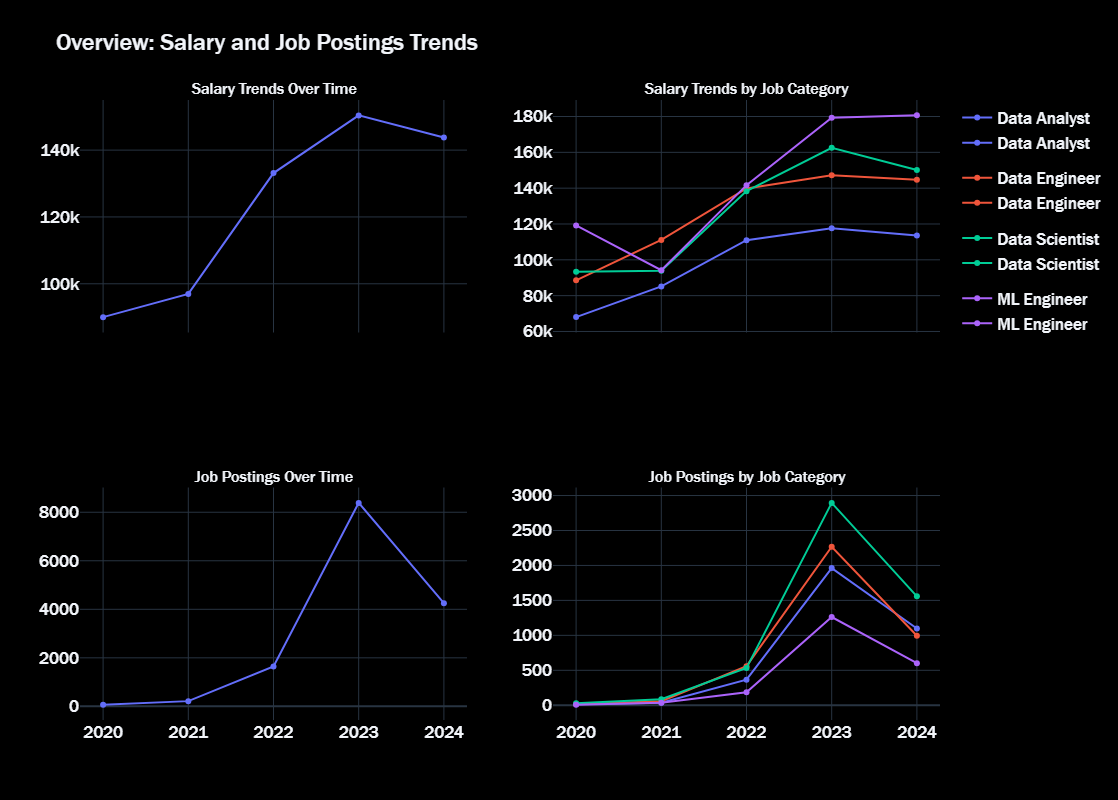

In [103]:
# 1st Chart: Salary Trends Over Time
salary_trends = dfSalaries.groupby(['work_year'])['salary_in_usd'].mean().reset_index()
fig1 = px.line(
    salary_trends, x='work_year', y='salary_in_usd',
    title='Salary Trends Over Time',
    markers=True, template='plotly_dark'
)

fig1.update_xaxes(tickvals=salary_trends['work_year'].unique(), tickformat='%Y')

# 2nd Chart: Salary Trends Over Time by Job Category
salary_trends_by_category = dfSalaries.groupby(['work_year', 'job_category'])['salary_in_usd'].mean().reset_index()
fig2 = px.line(
    salary_trends_by_category, x='work_year', y='salary_in_usd',
    color='job_category', title='Salary Trends Over Time by Job Category',
    markers=True, template='plotly_dark'
)

fig2.update_xaxes(tickvals=salary_trends_by_category['work_year'].unique(), tickformat='%Y')

# 3rd Chart: Job Postings Over Time
job_postings_over_time = dfSalaries.groupby(['work_year'])['job_category'].count().reset_index(name='count')
fig3 = px.line(
    job_postings_over_time, x='work_year', y='count',
    title='Job Postings Over Time',
    markers=True, template='plotly_dark'
)

fig3.update_xaxes(tickvals=job_postings_over_time['work_year'].unique(), tickformat='%Y')

# 4th Chart: Job Postings Over Time by Job Category
job_postings_by_category = dfSalaries.groupby(['work_year', 'job_category']).size().reset_index(name='count')
fig4 = px.line(
    job_postings_by_category, x='work_year', y='count',
    color='job_category', title='Job Postings Over Time by Job Category',
    markers=True, template='plotly_dark'
)

fig4.update_xaxes(tickvals=job_postings_by_category['work_year'].unique(), tickformat='%Y')

fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=(
        'Salary Trends Over Time', 'Salary Trends by Job Category',
        'Job Postings Over Time', 'Job Postings by Job Category'
    ),  
    shared_xaxes=True,  
    shared_yaxes=False 
)

# Add chart data to the subplots
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

for trace in fig3.data:
    fig.add_trace(trace, row=2, col=1)

for trace in fig4.data:
    fig.add_trace(trace, row=2, col=2)

# General layout settings
fig.update_layout(
    title='Overview: Salary and Job Postings Trends', 
    width=1000, height=800,  
    legend_title_text=None,  
    font=dict(size=17, family='Franklin Gothic'),  
    template='plotly_dark', 
    plot_bgcolor='#000000', paper_bgcolor='#000000', 
)

# Display the chart
fig.show()

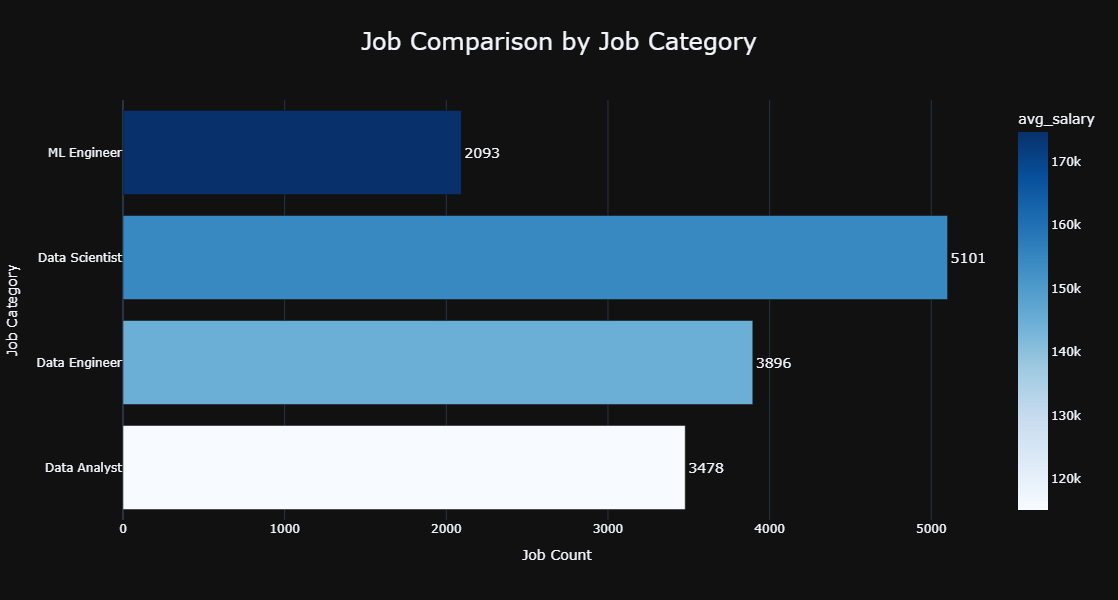

In [114]:
# Prepare the data: Group by job category and calculate the number of postings and average salary
job_postings_and_salary = (
    dfSalaries.groupby('job_category')
    .agg(
        job_posting_count=('job_category', 'size'),
        avg_salary=('salary_in_usd', 'mean')
    )
    .reset_index()
)

# Create the bar chart
fig = px.bar(
    job_postings_and_salary,
    x='job_posting_count', 
    y='job_category', 
    color='avg_salary', 
    color_continuous_scale='Blues',
    title='Job Comparison by Job Category', 
    text='job_posting_count', 
    width=1000, height=600,
    template='plotly_dark'
)

# Layout settings: Background and axis titles
fig.update_layout(
    xaxis_title='Job Count',  
    yaxis_title='Job Category', 
    title={'x': 0.5, 'font_size': 24}
)

# Adjust text size and position on bars
fig.update_traces(
    texttemplate='%{text}',  
    textposition='outside', 
    textfont_size=14  
)

# Display the chart
fig.show()

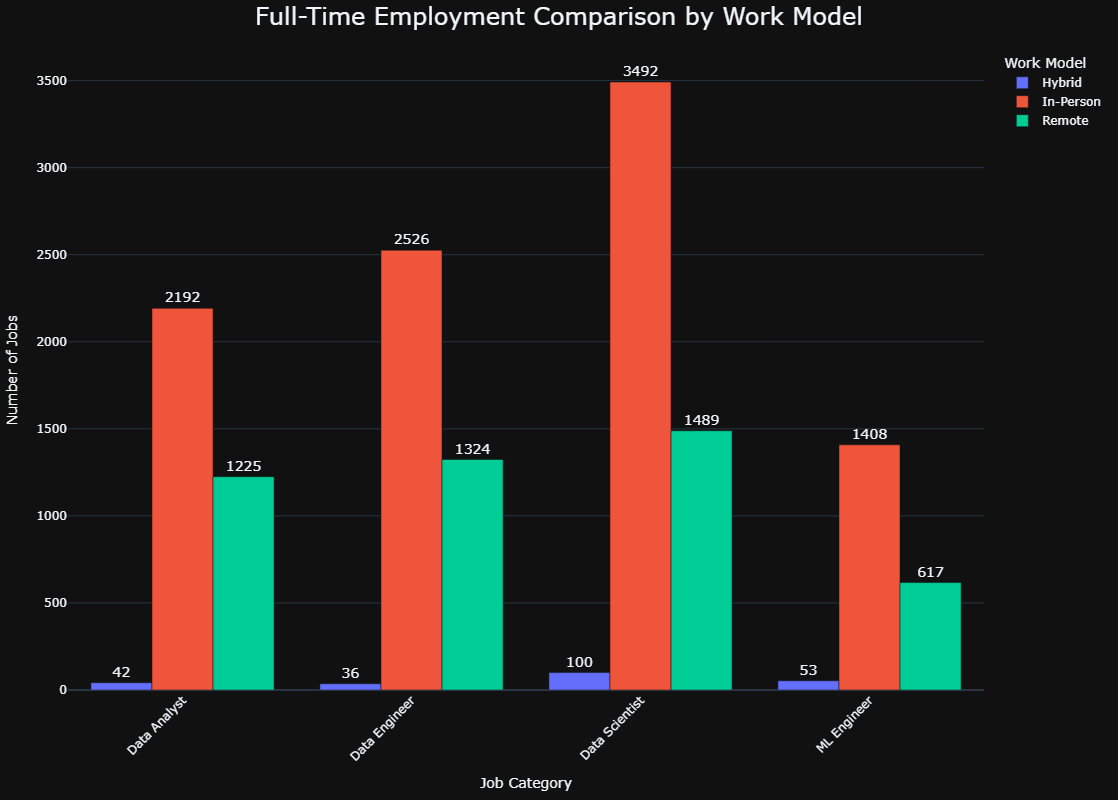

In [105]:
# Prepare data: Filter only 'full-time' employment type and group by job category and work model
job_data_full_time = (
    dfSalaries[dfSalaries['employment_type'] == 'Full-Time']
    .groupby(['job_category', 'employment_model'])
    .size()
    .reset_index(name='count')
)

# Create the clustered bar chart
fig = px.bar(
    job_data_full_time, 
    x='job_category',  
    y='count',  
    color='employment_model',
    barmode='group', 
    title='Full-Time Employment Comparison by Work Model', 
    labels={'count': 'Number of Jobs', 'job_category': 'Job Category'}, 
    width=1000, height=800,
    template='plotly_dark'
)

# Update layout for better spacing and alignment
fig.update_layout(
    title=dict(x=0.5, font_size=24), 
    xaxis_tickangle=-45, 
    legend_title='Work Model', 
    margin=dict(l=50, r=50, t=50, b=100) 
)

# Display job counts on top of the bars
fig.update_traces(
    texttemplate='%{y}', 
    textposition='outside', 
    textfont_size=14
)

# Display the chart
fig.show()

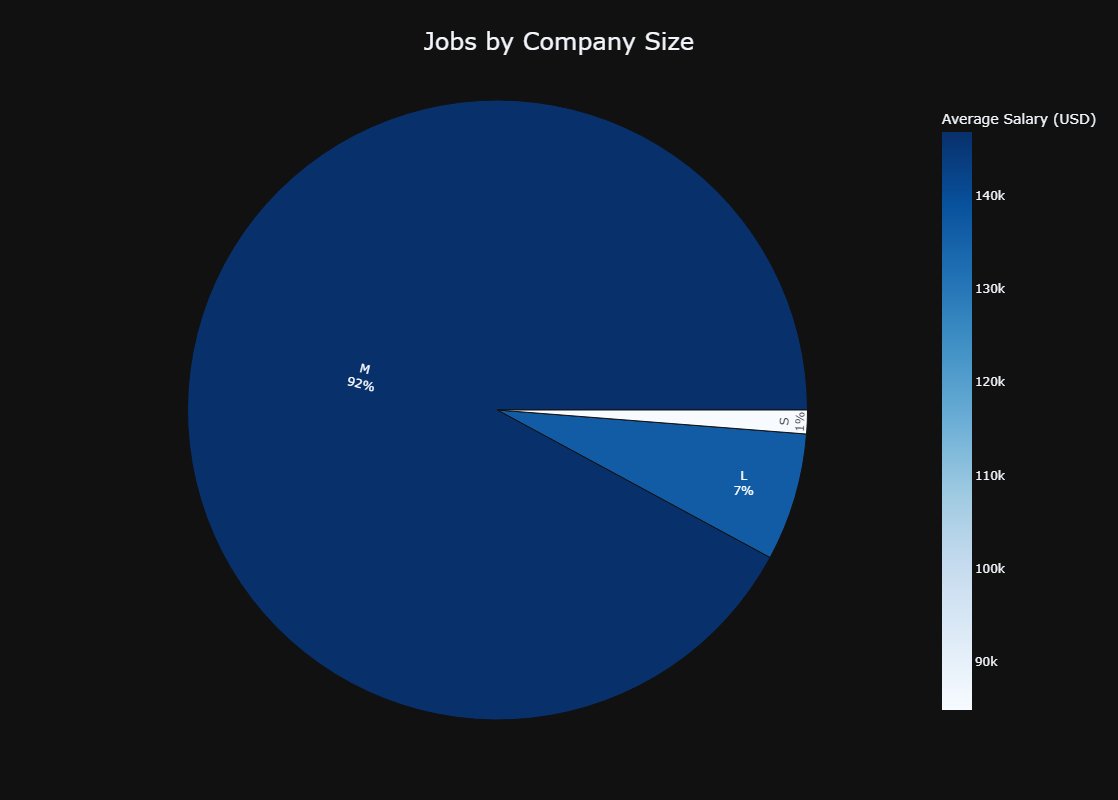

In [113]:
# Data preparation: Calculate the number of postings and average salary by Company Size
job_postings_and_salary = (
    dfSalaries.groupby('company_size')
    .agg(
        job_posting_count=('company_size', 'size'),
        avg_salary=('salary_in_usd', 'mean')
    )
    .reset_index()
)

# Calculate percentage of job postings
total_postings = job_postings_and_salary['job_posting_count'].sum()
job_postings_and_salary['percentage'] = (
    job_postings_and_salary['job_posting_count'] / total_postings * 100
).round(2)

# Create the Sunburst chart
fig = px.sunburst(
    job_postings_and_salary,
    path=['company_size'],
    values='job_posting_count',
    color='avg_salary',
    color_continuous_scale='Blues',
    title='Jobs by Company Size',  
    labels={
        'job_posting_count': 'Number of Job',
        'avg_salary': 'Average Salary (USD)'
    },
    width=800, height=800,  
    template='plotly_dark' 
)

# Layout settings: Center the title and adjust font size
fig.update_layout(
    title={'x': 0.5, 'font_size': 24},
)

# Add custom data to display number of postings and percentage in each slice
fig.update_traces(
    textinfo='label+text+percent entry', 
    customdata=job_postings_and_salary[['job_posting_count', 'percentage']],  
    hovertemplate=(
        '<b>%{label}</b><br>'
        'Number of Jobs: %{customdata[0]}<br>' 
        'Percentage: %{customdata[1]}%' 
    )
)

# Display the chart
fig.show()

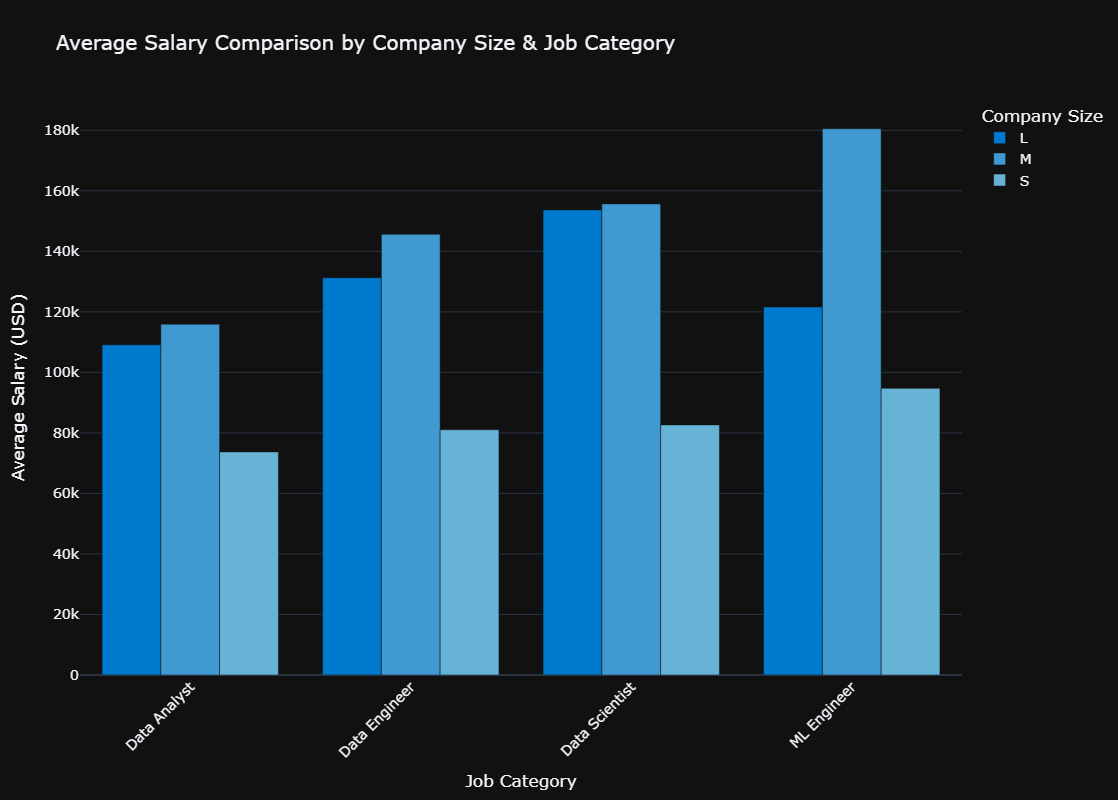

In [107]:
# Grouping by company_size, job_category, and salary_in_usd to calculate average salary
dfSalaries_grouped = dfSalaries.groupby(['company_size', 'job_category'])['salary_in_usd'].mean().reset_index()

# Create the bar chart (average salaries by company_size for each job_category)
fig = px.bar(
    dfSalaries_grouped, 
    x='job_category',  
    y='salary_in_usd', 
    color='company_size', 
    barmode='group', 
    title='Average Salary Comparison by Company Size & Job Category',  
    labels={
        'salary_in_usd': 'Average Salary (USD)', 
        'job_category': 'Job Category'
    },
    template='plotly_dark', 
    color_discrete_sequence=['#007acc', '#4199d1', '#66b3d6', '#8ccc9d'],  
    width=1000, height=800,  
)

# Customize the layout
fig.update_layout(
    xaxis_title='Job Category', 
    yaxis_title='Average Salary (USD)',  
    legend_title='Company Size',  
    font=dict(size=14),  
    xaxis_tickangle=-45  
)

# Display the chart
fig.show()

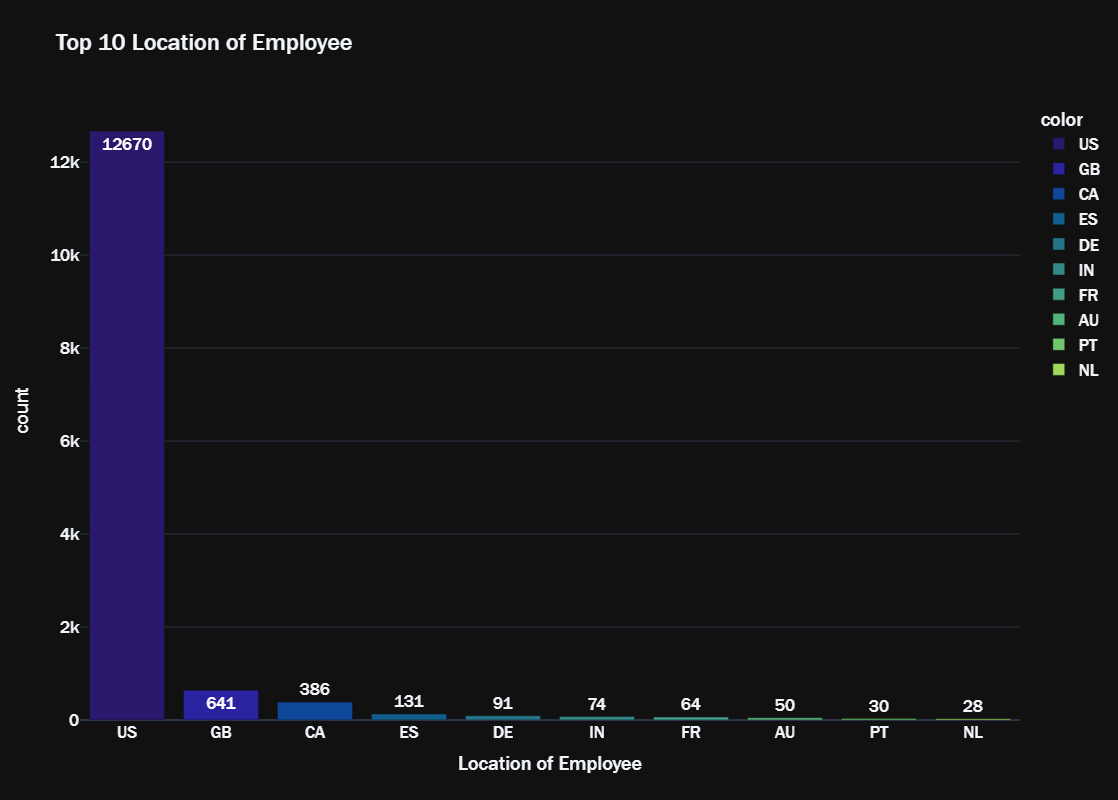

In [108]:
# Bar Chart: Job Postings by Top 10 Location of Employee

residence = dfSalaries['employee_residence'].value_counts()

top10_employee_location = residence[:10]

fig = px.bar(
    y=top10_employee_location.values,
    x=top10_employee_location.index,
    color = top10_employee_location.index,
    color_discrete_sequence=px.colors.sequential.haline,
    text=top10_employee_location.values,
    title= 'Top 10 Location of Employee',
    template= 'plotly_dark',
    width=1000, height=800, 
)

fig.update_layout(
    xaxis_title="Location of Employee",
    yaxis_title="count",
    font = dict(size=17,family="Franklin Gothic"))

fig.show()

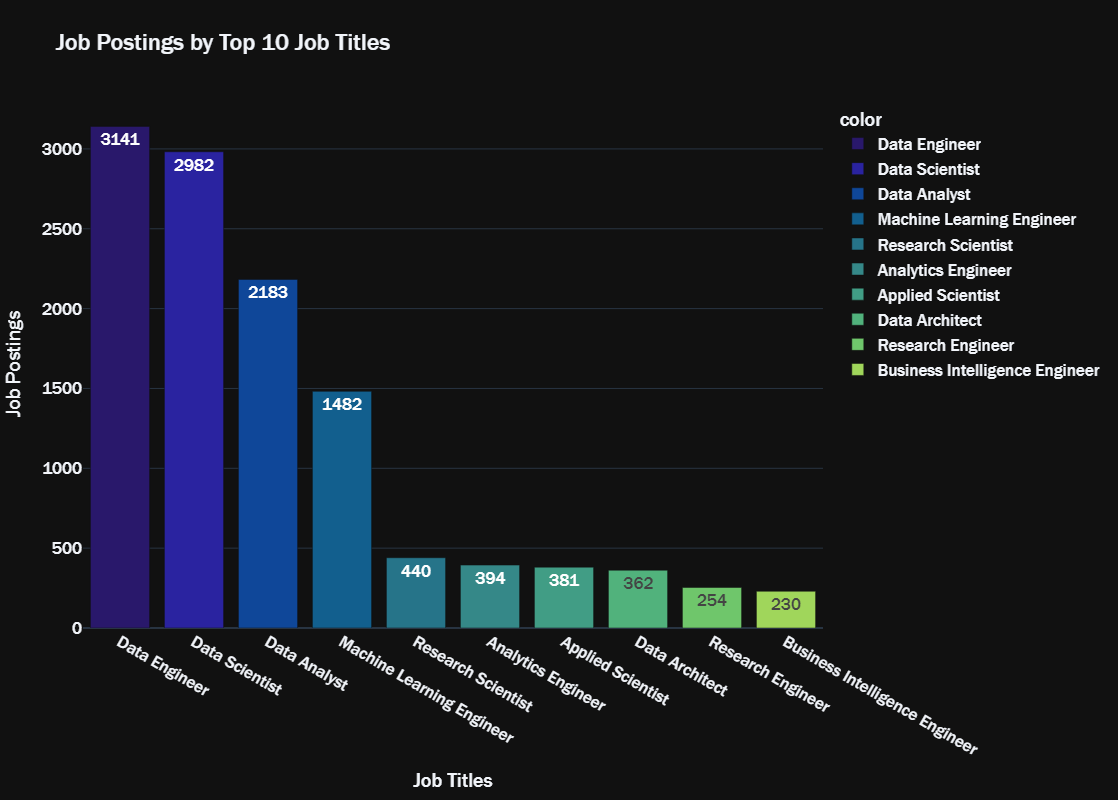

In [115]:
# Bar Chart: Job Postings by Top 10 Job Titles

top10_job_title = dfSalaries['job_title'].value_counts()[:10]

fig = px.bar(
    y=top10_job_title.values,
    x=top10_job_title.index,
    color = top10_job_title.index,
    color_discrete_sequence=px.colors.sequential.haline,
    text=top10_job_title.values,
    title= 'Job Postings by Top 10 Job Titles',
    template= 'plotly_dark',
    width=1000, height=800,  # Width and height
)

fig.update_layout(
    xaxis_title="Job Titles",
    yaxis_title="Job Postings",
    font = dict(size=17,family="Franklin Gothic"))

fig.show()